# Training a 3D CNN

In [1]:
import re
import pathlib
import torchvision

from fastai.basics import *
from fastai.medical.imaging import *
from fastai.vision.all import *
from fastai.callback.all import *
import fastai

from faimed3d.basics import *
from faimed3d.augment import *
from faimed3d.models import *
from faimed3d.data import *

In [2]:
torch.cuda.set_device(1)

## Designing a 3D CNN

In [3]:
class Sequential_(nn.Sequential):
    "Somehow, in 3D CNNs, the input is not transfered to cuda. I believe something in the transforms is wrong. Until this is fixed, subcalssing nn.Sequential is the workarround"
    def forward(self, input):
        for module in self:
            input = module(input.cuda())
        return input

def block(ni, nf, **kwargs): 
    return Sequential_(
        ResBlock(1, ni, nf, stride = (2,2,1), ndim = 3, **kwargs), 
        ResBlock(1, nf, nf, ndim = 3))

#def block(ni, nf, **kwargs): return ConvLayer(ni, nf, ndim = 3, **kwargs)

def get_model():
    return Sequential_(
        block(20, 64, ks = 7),
        block(64, 128, ks = 5),
        block(128, 256),
        block(256, 512),
        nn.AdaptiveAvgPool3d(1),
        Flatten(),
        nn.Linear(512, dls.c))

## Create Pytorch Dataloaders

In [4]:
train = pathlib.Path('../../dl-prostate-mapping/data/train')
valid = pathlib.Path('../../dl-prostate-mapping/data/valid')
test = pathlib.Path('../../dl-prostate-mapping/data/test')

train_files = list(train.rglob('DICOM'))
valid_files = list(valid.rglob('DICOM'))
test_files = list(test.rglob('DICOM'))

# take only T2 and T1 images for noe
subset_train =[]
for f in train_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_train.append(Path(m.string))
        
subset_valid =[]
for f in valid_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_valid.append(Path(m.string))
        
subset_test = []
for f in test_files: 
    m = re.search(r'T2', str(f)) 
    if hasattr(m, 'string'): subset_test.append(Path(m.string))
        
        
def label_func(fn):
    return re.findall(r'(Gesund|ProstataCa)', str(fn))[0]
labels = ['Gesund', 'ProstataCa']

In [5]:
oversampled_train = subset_train+ random.choices(subset_train[slice(0, 33)], k = 23)

In [6]:
labels = ['Gesund', 'ProstataCa']
def label_func(fn): return re.findall(r'(Gesund|ProstataCa)', str(fn))[0]

In [7]:
class ProstateDataset(torch.utils.data.Dataset):
    def __init__(self, files):
        self.files = files
        self.labels = [label_func(f) for f in files]
        self.tcat = Categorize(vocab=labels)
        self.c = len(labels)

    def load_3d_obj(self, fn=TensorDicom3D):
        t = TensorDicom3D.create(fn)
        return t.hist_scaled()
    
    def presize(self, t: TensorDicom3D):
        return ResizeCrop3D(crop_by = (0., 0.15, 0.15), resize_to = (20, 200, 200), perc_crop = True)(t)
    
    def apply_tfms(self, t: TensorDicom3D):
        return Pipeline([*aug_transforms_3d(p_all =1.), RandomCrop3D((0, 25, 25), (0, 10, 10)), PseudoColor])(t)
        
    def __getitem__(self, i):
        file = self.load_3d_obj(self.files[i])
        cls = self.tcat(self.labels[i])
        file = self.presize(file)
        file = self.apply_tfms(file)
        return (file, torch.Tensor([cls]).squeeze())
    
    def __len__(self): return len(self.files)
    
train_ds = ProstateDataset(oversampled_train*2) # fewer epochs, less clutter on the screen during training. Significant increase in accuracy does appear after 100-150 epochs (with single training subset)
valid_ds = ProstateDataset(subset_valid)
test_ds = ProstateDataset(subset_test)

In [8]:
train_dl = DataLoader(train_ds, 
          batch_size = 32, 
          pin_memory = False, 
          num_workers = 48)
valid_dl = DataLoader(valid_ds, 
          batch_size = 32, 
          pin_memory = False, 
          num_workers = 48)
test_dl = DataLoader(test_ds, 
          batch_size = 8, 
          pin_memory = False, 
          num_workers = 48)

dls = DataLoaders(train_dl, valid_dl, test_dl)

In [9]:
dls = dls.cuda()
def loss_func(out, targ):
    return CrossEntropyLossFlat()(out, targ.long())

In [10]:
roc = RocAucBinary()

In [11]:
learn = Learner(dls, get_model(), opt_func = SGD, loss_func = loss_func, metrics = [error_rate, roc], cbs=ActivationStats(with_hist=True))
learn = learn.to_fp16()

In [12]:
#learn.lr_find()

In [25]:
learn.fit_one_cycle(n_epoch = 5, lr_max = 0.005)

epoch,train_loss,valid_loss,error_rate,roc_auc_score,time
0,0.699911,0.673427,0.450000,0.750000,01:48
1,0.726954,0.668231,0.500000,0.770000,01:47
2,0.730709,0.665433,0.500000,0.720000,01:48
3,0.723666,0.657580,0.400000,0.780000,01:48
4,0.713327,0.662481,0.500000,0.780000,01:49


In [26]:
preds, target = learn.get_preds()

In [33]:
preds, target

(array([0.39999017, 0.44896975, 0.45565274, 0.4656001 , 0.48950347,
        0.3840906 , 0.42865187, 0.4821243 , 0.40839475, 0.34073195,
        0.53266823, 0.48706344, 0.42196864, 0.47432682, 0.441041  ,
        0.50128174, 0.48544723, 0.49548355, 0.44939265, 0.41655928],
       dtype=float32),
 tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1.]))

In [27]:
preds = F.softmax(preds, dim = 1)[:, 1].numpy()

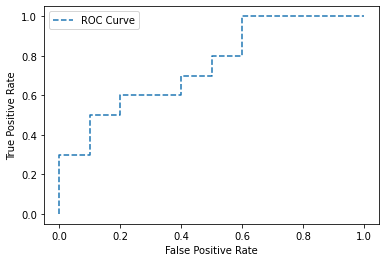

In [28]:
from sklearn.metrics import roc_curve
ns_fpr, ns_tpr, _ = roc_curve(target.numpy(), preds)
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [31]:
learn.save('custom-resnet')

Path('models/custom-resnet.pth')